In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import numpy as np
import imp
from scipy.stats import theilslopes

sn.set_context('talk')

In [2]:
# Import custom functions
func_path = (r'C:\Data\James_Work\Staff\Heleen_d_W\ICP_Waters\TOC_Trends_Analysis_2015'
             r'\Python\icpw\toc_trends_analysis.py')

icpw = imp.load_source('toc_trends_analysis', func_path)

# Rolling Sen's slope

Basic proof of concept for rolling Sen's slope idea.

Key questions:

1. Is TOC increasing (and, if so, is the trend significant)? <br><br>

2. Is the rate of increase slowing (and, if so, is the slowing trend significant)?

## 1. Generate fake data

First create some "toy" TOC data to experiment with. The data is noisy, but it initially increases rapidly and then levels off.

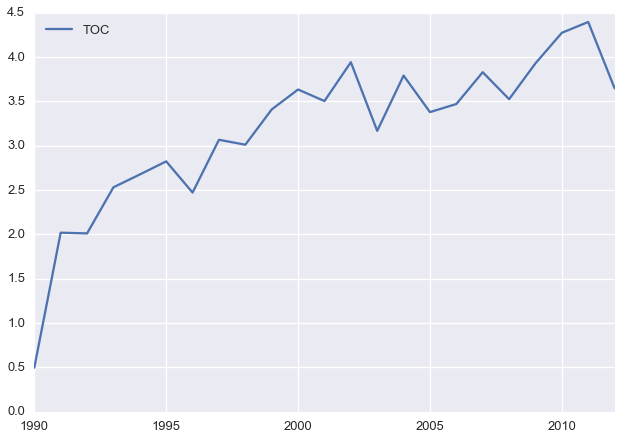

In [3]:
# Fake data
# Rising TOC, but *rise rate* decreasing through time
x = np.arange(1990, 2013)
y = np.log(1.5*(x-1989)) + np.random.uniform(low=0, high=1, size=len(x))
df = pd.DataFrame({'TOC':y}, index=x)
df.plot()

## 2. Is TOC increasing?

We've already tested for this. Use Sen's slope to estimate the overall rate of change and then a Mann-Kendall test for significance.

M-K test results: increasing (p=0.0000)


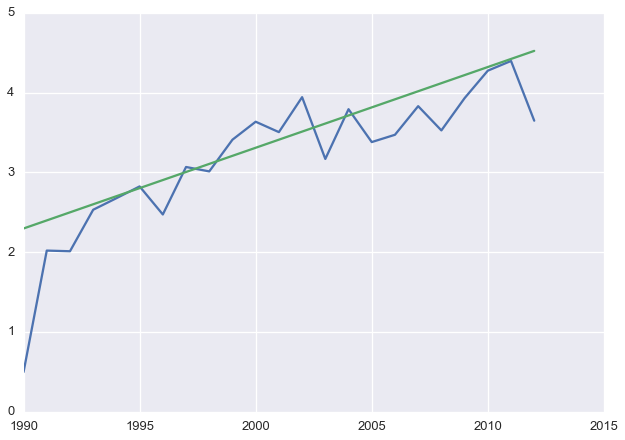

In [4]:
# M-K test
res = icpw.mk_test(df['TOC'].values, 'test_stn', 'TOC')

print 'M-K test results: %s (p=%.4f)' % (res[4], res[3])

# Sen's slope
slp, intcp, lo, hi = theilslopes(y, x)

# Plot
y2 = slp*x + intcp
plt.plot(x, y)
plt.plot(x, y2)

So there is an **increasing overall trend** (as we often find in our real data).

## 3. Is the rate of increase changing through time?

Idea: 

* Calculate Sen's slope using a 10-year moving window to give the rate of change through time <br><br>

* Use an M-K to test to see if there is a significant trend in this rate of change

**NB:** A 12 year moving window works well for a 22 year period: the minimum number of data points for reasonably robust M-K test is ~10, so using a 12 year window means the slope estimate for each segment is fairly robust. In addition, there are 12 twelve-year windows in a 22 year period, so the output is also large enough for a reliable trend test.

In [5]:
# Function for moving window
def sens_slp(df):
    """ Calculate Sen's slope estimate.
    """
    from scipy.stats import theilslopes
    
    res = theilslopes(df)
    
    return res[0]

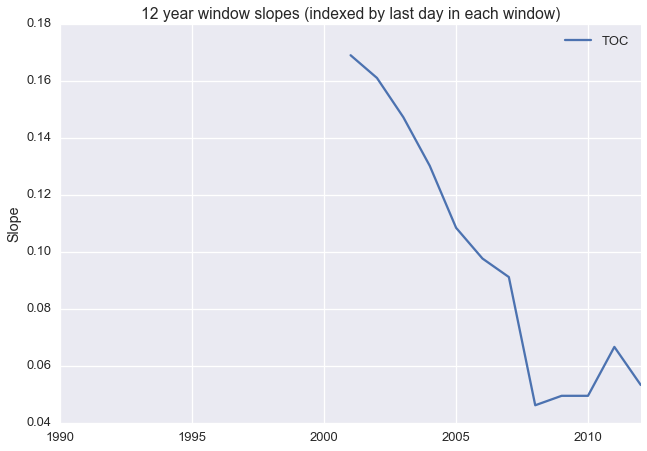

In [6]:
# Calc rolling slopes
df2 = df.rolling(center=False, window=12).apply(func=sens_slp)
df2.plot()
plt.title('12 year window slopes (indexed by last day in each window)')
plt.ylabel('Slope')

In general, the slopes seem to decrease through time, but is this change significant?

M-K test results: decreasing (p=0.0010)


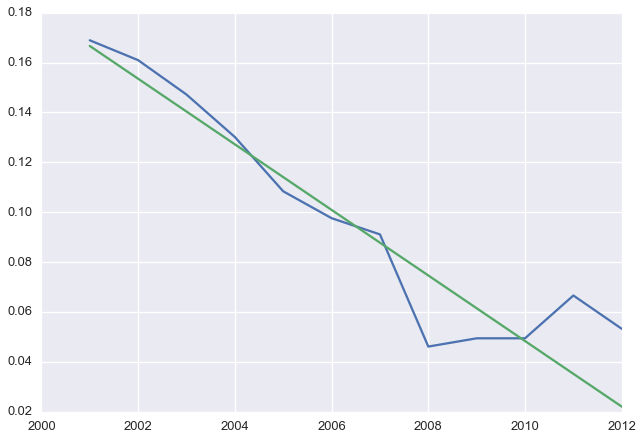

In [7]:
# Drop Nan
df2.dropna(inplace=True)

# M-K test
res = icpw.mk_test(df2['TOC'].values, 'test_stn', 'TOC')

print 'M-K test results: %s (p=%.4f)' % (res[4], res[3])

# Sen's slope
slp, intcp, lo, hi = theilslopes(df2['TOC'], df2.index)

# Plot
y3 = slp*df2.index + intcp
plt.plot(df2.index, df2['TOC'])
plt.plot(df2.index, y3)

So there is evidience for a **significant decrease** in the rate of increase of TOC through time.

## 4. Quick visual check that the moving window is working sensibly

Plot the slope line for each 12-year segment.

In [8]:
def sens_intcp(df):
    """ Get intercept to go with slope estimate.
    """
    from scipy.stats import theilslopes
        
    res = theilslopes(df)
    
    return res[1]

In [9]:
# Get intercepts
incpts = df.rolling(center=False,window=10).apply(func=sens_intcp)
incpts.columns = ['c']

df2 = df2.join(incpts)
df2

,TOC,c
2001,0.168947,2.252761
2002,0.160975,2.346688
2003,0.147190,2.457168
2004,0.130159,2.703649
2005,0.108387,2.928394
2006,0.097607,3.226503
2007,0.091108,3.250827
2008,0.046118,3.457376
2009,0.049435,3.455002
2010,0.049435,3.414056


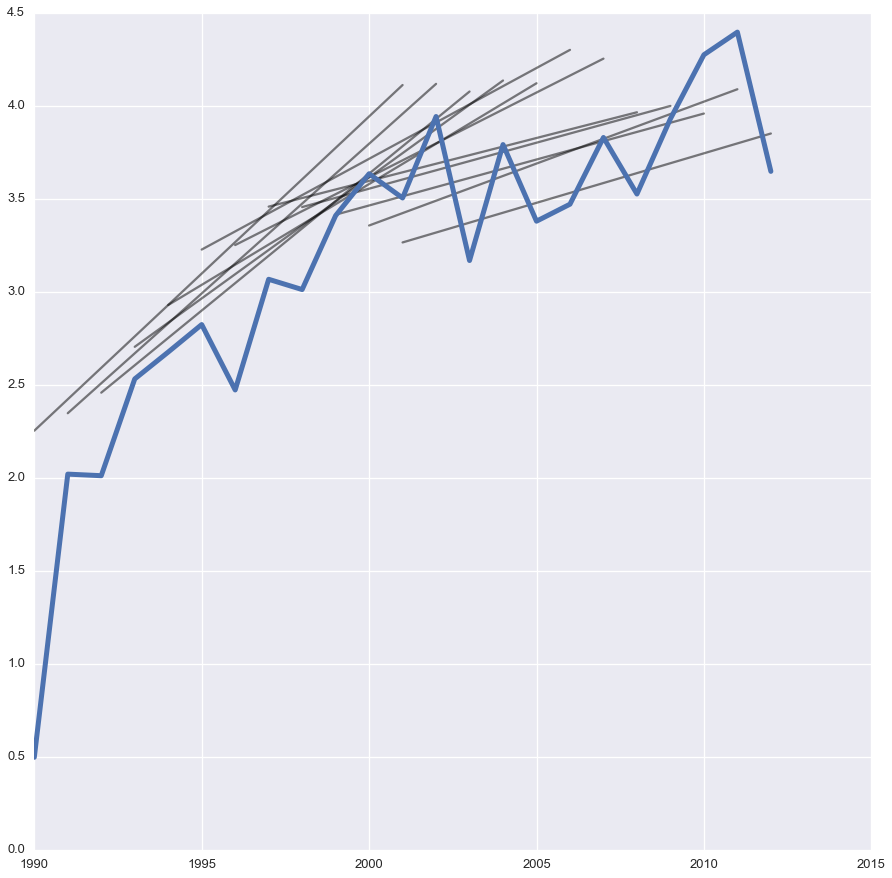

In [10]:
fig = plt.figure(figsize=(15, 15))

# Plot slopes for each 10 year window
for yr in range(2001, 2013):
    xi = np.arange(yr-11, yr+1)
    slp = df2.ix[yr, 'TOC']
    inc = df2.ix[yr, 'c']
    yi = slp*(xi-yr+11) + inc
    plt.plot(xi, yi, c='k', alpha=0.5)

# Original data
plt.plot(x, y, lw=5)

This looks reasonable at first glance.